#Enlace a GitHub

https://github.com/Sebastian-Cepeda-Ch/SIS421-2025-ASCC

In [1]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Instalar las bibliotecas necesarias
!pip install transformers
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
# Importar bibliotecas
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

In [3]:
# Función para leer párrafos de los archivos
def leer_parrafos(archivo):
    with open(archivo, 'r', encoding='utf-8') as f:
        contenido = f.read()
    parrafos = [p.strip() for p in contenido.split('*') if p.strip()]
    return parrafos

In [4]:
# Ruta al dataset
ruta = '/content/drive/MyDrive/SIS421/Laboratorios/Datasets/NLP/dataset_documentos'

In [5]:
# Leer los archivos y asignar etiquetas
parrafos_estudiantes = leer_parrafos(ruta + '/estudiantes.txt')
etiquetas_estudiantes = [0] * len(parrafos_estudiantes)

parrafos_docentes = leer_parrafos(ruta + '/docentes.txt')
etiquetas_docentes = [1] * len(parrafos_docentes)

parrafos_administrativos = leer_parrafos(ruta + '/administrativos.txt')
etiquetas_administrativos = [2] * len(parrafos_administrativos)

parrafos_general = leer_parrafos(ruta + '/general.txt')
etiquetas_general = [3] * len(parrafos_general)

In [6]:
# Combinar todos los párrafos y etiquetas
todos_parrafos = parrafos_estudiantes + parrafos_docentes + parrafos_administrativos + parrafos_general
todas_etiquetas = etiquetas_estudiantes + etiquetas_docentes + etiquetas_administrativos + etiquetas_general

# Dividir en conjuntos de entrenamiento y prueba
train_texts, test_texts, train_labels, test_labels = train_test_split(
    todos_parrafos, todas_etiquetas, test_size=0.2, random_state=42
)

In [7]:
# Definir la clase personalizada para el dataset
class TextoDataset(Dataset):
    def __init__(self, textos, etiquetas, tokenizer, max_length=512):
        self.textos = textos
        self.etiquetas = etiquetas
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.textos)

    def __getitem__(self, idx):
        texto = self.textos[idx]
        etiqueta = self.etiquetas[idx]
        encoding = self.tokenizer(
            texto, padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(etiqueta, dtype=torch.long)
        }

In [8]:
# Cargar el tokenizador
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Crear los datasets de entrenamiento y prueba
train_dataset = TextoDataset(train_texts, train_labels, tokenizer)
test_dataset = TextoDataset(test_texts, test_labels, tokenizer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [9]:
# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Cargar el modelo BERT para clasificación
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Mover el modelo a la GPU si está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [11]:
# Definir el optimizador y la función de pérdida
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = CrossEntropyLoss()

In [12]:
# Función de entrenamiento manual
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc="Entrenando"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

In [13]:
# Función de evaluación manual
def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluando"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    return total_loss / len(test_loader), accuracy

In [14]:
# Entrenamiento y evaluación manual
from pathlib import Path
import torch

# Directorio para guardar checkpoints (añade esto al inicio del código)
CHECKPOINT_DIR = "/content/drive/MyDrive/SIS421/Laboratorios/Datasets/NLP"
Path(CHECKPOINT_DIR).mkdir(parents=True, exist_ok=True)  # Crea la carpeta si no existe

num_epochs = 30
best_test_loss = float('inf') # Para guardar el mejor modelo

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Entrenamiento y evaluación

    train_loss = train(model, train_loader, optimizer, criterion, device)
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)

    # --- CHECKPOINT: Guardar modelo cada época o cuando mejore la pérdida ---
    checkpoint_path = f"{CHECKPOINT_DIR}/checkpoint_epoch_{epoch+1}.pt"

    #Guardar solo si el modelo mejora (recomendado)
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'test_loss': test_loss,
            'test_accuracy': test_accuracy,
        }, f"{CHECKPOINT_DIR}/best_model.pt")  # Guarda solo el mejor

    print(f"Checkpoint guardado en {checkpoint_path}")
    print(f"Pérdida de entrenamiento: {train_loss:.4f}")
    print(f"Pérdida de prueba: {test_loss:.4f}, Precisión en prueba: {test_accuracy:.4f}")


Epoch 1/30


Evaluando: 100%|██████████| 16/16 [00:03<00:00,  4.59it/s]


Checkpoint guardado en /content/drive/MyDrive/SIS421/Laboratorios/Datasets/NLP/checkpoint_epoch_1.pt
Pérdida de entrenamiento: 1.3729
Pérdida de prueba: 1.2683, Precisión en prueba: 0.4480

Epoch 2/30


Evaluando: 100%|██████████| 16/16 [00:03<00:00,  4.31it/s]


Checkpoint guardado en /content/drive/MyDrive/SIS421/Laboratorios/Datasets/NLP/checkpoint_epoch_2.pt
Pérdida de entrenamiento: 0.8070
Pérdida de prueba: 0.4479, Precisión en prueba: 0.9040

Epoch 3/30


Evaluando: 100%|██████████| 16/16 [00:03<00:00,  4.32it/s]


Checkpoint guardado en /content/drive/MyDrive/SIS421/Laboratorios/Datasets/NLP/checkpoint_epoch_3.pt
Pérdida de entrenamiento: 0.3320
Pérdida de prueba: 0.3453, Precisión en prueba: 0.9280

Epoch 4/30


Evaluando: 100%|██████████| 16/16 [00:03<00:00,  4.28it/s]


Checkpoint guardado en /content/drive/MyDrive/SIS421/Laboratorios/Datasets/NLP/checkpoint_epoch_4.pt
Pérdida de entrenamiento: 0.2309
Pérdida de prueba: 0.3610, Precisión en prueba: 0.9120

Epoch 5/30


Evaluando: 100%|██████████| 16/16 [00:03<00:00,  4.36it/s]


Checkpoint guardado en /content/drive/MyDrive/SIS421/Laboratorios/Datasets/NLP/checkpoint_epoch_5.pt
Pérdida de entrenamiento: 0.1875
Pérdida de prueba: 0.4169, Precisión en prueba: 0.8880

Epoch 6/30


Evaluando: 100%|██████████| 16/16 [00:03<00:00,  4.40it/s]


Checkpoint guardado en /content/drive/MyDrive/SIS421/Laboratorios/Datasets/NLP/checkpoint_epoch_6.pt
Pérdida de entrenamiento: 0.0916
Pérdida de prueba: 0.4025, Precisión en prueba: 0.9120

Epoch 7/30


Evaluando: 100%|██████████| 16/16 [00:03<00:00,  4.42it/s]


Checkpoint guardado en /content/drive/MyDrive/SIS421/Laboratorios/Datasets/NLP/checkpoint_epoch_7.pt
Pérdida de entrenamiento: 0.0654
Pérdida de prueba: 0.3906, Precisión en prueba: 0.9200

Epoch 8/30


Evaluando: 100%|██████████| 16/16 [00:03<00:00,  4.40it/s]


Checkpoint guardado en /content/drive/MyDrive/SIS421/Laboratorios/Datasets/NLP/checkpoint_epoch_8.pt
Pérdida de entrenamiento: 0.0556
Pérdida de prueba: 0.3677, Precisión en prueba: 0.9120

Epoch 9/30


Evaluando: 100%|██████████| 16/16 [00:03<00:00,  4.43it/s]


Checkpoint guardado en /content/drive/MyDrive/SIS421/Laboratorios/Datasets/NLP/checkpoint_epoch_9.pt
Pérdida de entrenamiento: 0.0481
Pérdida de prueba: 0.4193, Precisión en prueba: 0.9280

Epoch 10/30


Evaluando: 100%|██████████| 16/16 [00:03<00:00,  4.22it/s]


Checkpoint guardado en /content/drive/MyDrive/SIS421/Laboratorios/Datasets/NLP/checkpoint_epoch_10.pt
Pérdida de entrenamiento: 0.0360
Pérdida de prueba: 0.3719, Precisión en prueba: 0.9200

Epoch 11/30


Evaluando: 100%|██████████| 16/16 [00:03<00:00,  4.41it/s]


Checkpoint guardado en /content/drive/MyDrive/SIS421/Laboratorios/Datasets/NLP/checkpoint_epoch_11.pt
Pérdida de entrenamiento: 0.0215
Pérdida de prueba: 0.4323, Precisión en prueba: 0.9280

Epoch 12/30


Evaluando: 100%|██████████| 16/16 [00:03<00:00,  4.43it/s]


Checkpoint guardado en /content/drive/MyDrive/SIS421/Laboratorios/Datasets/NLP/checkpoint_epoch_12.pt
Pérdida de entrenamiento: 0.0241
Pérdida de prueba: 0.5584, Precisión en prueba: 0.8800

Epoch 13/30


Evaluando: 100%|██████████| 16/16 [00:03<00:00,  4.41it/s]


Checkpoint guardado en /content/drive/MyDrive/SIS421/Laboratorios/Datasets/NLP/checkpoint_epoch_13.pt
Pérdida de entrenamiento: 0.1313
Pérdida de prueba: 0.4330, Precisión en prueba: 0.9040

Epoch 14/30


Evaluando: 100%|██████████| 16/16 [00:03<00:00,  4.43it/s]


Checkpoint guardado en /content/drive/MyDrive/SIS421/Laboratorios/Datasets/NLP/checkpoint_epoch_14.pt
Pérdida de entrenamiento: 0.0789
Pérdida de prueba: 0.4822, Precisión en prueba: 0.8800

Epoch 15/30


Evaluando: 100%|██████████| 16/16 [00:03<00:00,  4.39it/s]


Checkpoint guardado en /content/drive/MyDrive/SIS421/Laboratorios/Datasets/NLP/checkpoint_epoch_15.pt
Pérdida de entrenamiento: 0.0367
Pérdida de prueba: 0.5115, Precisión en prueba: 0.9120

Epoch 16/30


Evaluando: 100%|██████████| 16/16 [00:03<00:00,  4.36it/s]


Checkpoint guardado en /content/drive/MyDrive/SIS421/Laboratorios/Datasets/NLP/checkpoint_epoch_16.pt
Pérdida de entrenamiento: 0.0183
Pérdida de prueba: 0.5014, Precisión en prueba: 0.9120

Epoch 17/30


Evaluando: 100%|██████████| 16/16 [00:03<00:00,  4.41it/s]


Checkpoint guardado en /content/drive/MyDrive/SIS421/Laboratorios/Datasets/NLP/checkpoint_epoch_17.pt
Pérdida de entrenamiento: 0.0145
Pérdida de prueba: 0.4980, Precisión en prueba: 0.9200

Epoch 18/30


Evaluando: 100%|██████████| 16/16 [00:03<00:00,  4.41it/s]


Checkpoint guardado en /content/drive/MyDrive/SIS421/Laboratorios/Datasets/NLP/checkpoint_epoch_18.pt
Pérdida de entrenamiento: 0.0118
Pérdida de prueba: 0.5293, Precisión en prueba: 0.9200

Epoch 19/30


Evaluando: 100%|██████████| 16/16 [00:03<00:00,  4.39it/s]


Checkpoint guardado en /content/drive/MyDrive/SIS421/Laboratorios/Datasets/NLP/checkpoint_epoch_19.pt
Pérdida de entrenamiento: 0.0104
Pérdida de prueba: 0.5189, Precisión en prueba: 0.9200

Epoch 20/30


Evaluando: 100%|██████████| 16/16 [00:03<00:00,  4.43it/s]


Checkpoint guardado en /content/drive/MyDrive/SIS421/Laboratorios/Datasets/NLP/checkpoint_epoch_20.pt
Pérdida de entrenamiento: 0.0107
Pérdida de prueba: 0.5345, Precisión en prueba: 0.9200

Epoch 21/30


Evaluando: 100%|██████████| 16/16 [00:03<00:00,  4.38it/s]


Checkpoint guardado en /content/drive/MyDrive/SIS421/Laboratorios/Datasets/NLP/checkpoint_epoch_21.pt
Pérdida de entrenamiento: 0.0110
Pérdida de prueba: 0.5375, Precisión en prueba: 0.9200

Epoch 22/30


Evaluando: 100%|██████████| 16/16 [00:03<00:00,  4.35it/s]


Checkpoint guardado en /content/drive/MyDrive/SIS421/Laboratorios/Datasets/NLP/checkpoint_epoch_22.pt
Pérdida de entrenamiento: 0.0119
Pérdida de prueba: 0.5210, Precisión en prueba: 0.9200

Epoch 23/30


Evaluando: 100%|██████████| 16/16 [00:03<00:00,  4.41it/s]


Checkpoint guardado en /content/drive/MyDrive/SIS421/Laboratorios/Datasets/NLP/checkpoint_epoch_23.pt
Pérdida de entrenamiento: 0.0110
Pérdida de prueba: 0.5231, Precisión en prueba: 0.9200

Epoch 24/30


Evaluando: 100%|██████████| 16/16 [00:03<00:00,  4.42it/s]


Checkpoint guardado en /content/drive/MyDrive/SIS421/Laboratorios/Datasets/NLP/checkpoint_epoch_24.pt
Pérdida de entrenamiento: 0.0092
Pérdida de prueba: 0.5397, Precisión en prueba: 0.9200

Epoch 25/30


Evaluando: 100%|██████████| 16/16 [00:03<00:00,  4.42it/s]


Checkpoint guardado en /content/drive/MyDrive/SIS421/Laboratorios/Datasets/NLP/checkpoint_epoch_25.pt
Pérdida de entrenamiento: 0.0095
Pérdida de prueba: 0.5442, Precisión en prueba: 0.9200

Epoch 26/30


Evaluando: 100%|██████████| 16/16 [00:03<00:00,  4.36it/s]


Checkpoint guardado en /content/drive/MyDrive/SIS421/Laboratorios/Datasets/NLP/checkpoint_epoch_26.pt
Pérdida de entrenamiento: 0.0096
Pérdida de prueba: 0.5543, Precisión en prueba: 0.9200

Epoch 27/30


Evaluando: 100%|██████████| 16/16 [00:03<00:00,  4.39it/s]


Checkpoint guardado en /content/drive/MyDrive/SIS421/Laboratorios/Datasets/NLP/checkpoint_epoch_27.pt
Pérdida de entrenamiento: 0.0087
Pérdida de prueba: 0.5475, Precisión en prueba: 0.9200

Epoch 28/30


Evaluando: 100%|██████████| 16/16 [00:03<00:00,  4.43it/s]


Checkpoint guardado en /content/drive/MyDrive/SIS421/Laboratorios/Datasets/NLP/checkpoint_epoch_28.pt
Pérdida de entrenamiento: 0.0094
Pérdida de prueba: 0.5626, Precisión en prueba: 0.9200

Epoch 29/30


Evaluando: 100%|██████████| 16/16 [00:03<00:00,  4.45it/s]


Checkpoint guardado en /content/drive/MyDrive/SIS421/Laboratorios/Datasets/NLP/checkpoint_epoch_29.pt
Pérdida de entrenamiento: 0.0093
Pérdida de prueba: 0.5732, Precisión en prueba: 0.9200

Epoch 30/30


Evaluando: 100%|██████████| 16/16 [00:03<00:00,  4.42it/s]

Checkpoint guardado en /content/drive/MyDrive/SIS421/Laboratorios/Datasets/NLP/checkpoint_epoch_30.pt
Pérdida de entrenamiento: 0.0098
Pérdida de prueba: 0.5789, Precisión en prueba: 0.9280


In [16]:
# Definir las clases
CLASES = {
    0: "Estudiantes",
    1: "Docentes",
    2: "Administrativos",
    3: "General"
}
def inferir_clase(texto, model_path, tokenizer_path, max_length=512):
    """
    Función para inferir la clase de un texto dado usando un modelo BERT entrenado.

    Args:
        texto (str): El texto a clasificar.
        model_path (str): Ruta al directorio donde se guardó el modelo entrenado.
        tokenizer_path (str): Ruta al directorio donde se guardó el tokenizador.
        max_length (int): Longitud máxima de la secuencia para el tokenizador.

    Returns:
        str: La clase predicha del texto.
    """
    # Cargar el tokenizador y el modelo
    tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
    model = BertForSequenceClassification.from_pretrained(model_path)

    # Mover el modelo a la GPU si está disponible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Tokenizar el texto
    encoding = tokenizer(
        texto,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

    # Mover los tensores al dispositivo adecuado
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Realizar la inferencia
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        prediccion = torch.argmax(logits, dim=1).item()

    # Devolver la clase predicha
    return CLASES[prediccion]

In [15]:
#Para cargar el modelo de ser necesario
import torch

# Ruta al checkpoint que quieres cargar (el mejor modelo en este caso)
checkpoint_path = "/content/drive/MyDrive/SIS421/Laboratorios/Datasets/NLP/best_model.pt"

# Cargar el diccionario del checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)

# Restaurar el estado del modelo y del optimizador
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']
test_loss = checkpoint['test_loss']
test_accuracy = checkpoint['test_accuracy']

print(f"✅ Modelo cargado desde la época {start_epoch}")
print(f"📉 Pérdida de prueba: {test_loss:.4f}, 📈 Precisión: {test_accuracy:.4f}")

In [ ]:
#Evaluar el modelo cargado
# Evaluar el modelo cargado
test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
print(f"🔍 Evaluación del modelo cargado: Loss = {test_loss:.4f}, Accuracy = {test_accuracy:.4f}")


In [18]:
#Guardar el modelo entrenado (opcional)
model.save_pretrained('/content/drive/MyDrive/SIS421/Laboratorios/Datasets/NLP/dataset_documentos/bert_model_manual')
tokenizer.save_pretrained('/content/drive/MyDrive/SIS421/Laboratorios/Datasets/NLP/dataset_documentos/bert_tokenizer_manual')

('/content/drive/MyDrive/SIS421/Laboratorios/Datasets/NLP/dataset_documentos/bert_tokenizer_manual/tokenizer_config.json',
 '/content/drive/MyDrive/SIS421/Laboratorios/Datasets/NLP/dataset_documentos/bert_tokenizer_manual/special_tokens_map.json',
 '/content/drive/MyDrive/SIS421/Laboratorios/Datasets/NLP/dataset_documentos/bert_tokenizer_manual/vocab.txt',
 '/content/drive/MyDrive/SIS421/Laboratorios/Datasets/NLP/dataset_documentos/bert_tokenizer_manual/added_tokens.json')

In [19]:
model_path = '/content/drive/MyDrive/SIS421/Laboratorios/Datasets/NLP/dataset_documentos/bert_model_manual'
tokenizer_path = '/content/drive/MyDrive/SIS421/Laboratorios/Datasets/NLP/dataset_documentos/bert_tokenizer_manual'
texto_ejemplo = "Profundizar conocimiento de actualidad socialmente útiles de su profesión para la solución de problemas técnicos consustanciados a la investigación científica básica y aplicada."

clase_predicha = inferir_clase(texto_ejemplo, model_path, tokenizer_path)
print(f"El texto pertenece a la clase: {clase_predicha}")

El texto pertenece a la clase: Estudiantes


#Metricas


In [29]:
import torch

best_ckpt_path = "/content/drive/MyDrive/SIS421/Laboratorios/Datasets/NLP/best_model.pt"
checkpoint = torch.load(best_ckpt_path, map_location='cpu')

epoch = checkpoint['epoch']
test_loss = checkpoint['test_loss']
test_accuracy = checkpoint['test_accuracy']

print(f"🌟 Mejor modelo en época: {epoch}")
print(f"📉 Pérdida de prueba: {test_loss:.4f}")
print(f"📈 Precisión de prueba: {test_accuracy:.4f}")

🌟 Mejor modelo en época: 3
📉 Pérdida de prueba: 0.3453
📈 Precisión de prueba: 0.9280


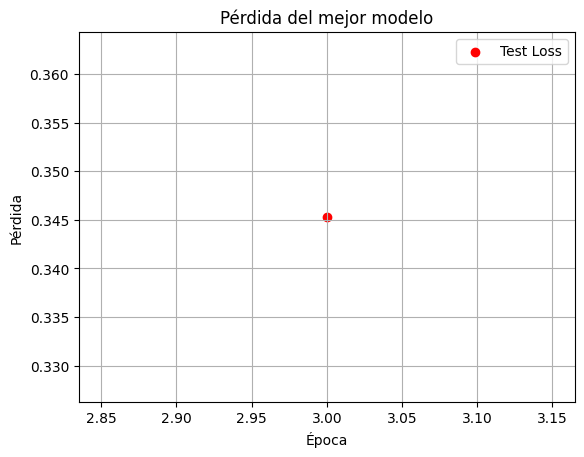

In [31]:
import matplotlib.pyplot as plt

# Solo un punto (poco útil como curva)
plt.figure()
plt.scatter([epoch], [test_loss], color='red', label='Test Loss')
plt.title('Pérdida del mejor modelo')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()